Reference: Data Professor bioinformatic project

https://www.youtube.com/watch?v=plVLRashaA8&list=PLtqF5YXg7GLlQJUv9XJ3RWdd5VYGwBHrP

# Step 1 Get data from database (ChEMBL)

In [ ]:
# silence execution, remove %%capture if you want to see output
%%capture
# install package to retrive information from chebml database
! pip install chembl_webresource_client
! pip install pycaret
# import two libraries for now
import pandas as pd
from chembl_webresource_client.new_client import new_client

In [ ]:
# find any target or disease you like, and type in the quotation.
target = new_client.target
# when you type a disease below, sometimes it won't show anything, for example: "blood disease"
# workaround is to google protein related to that target, forexample: "BTK" relates to "blood disease"
target_query = target.search('%MET%')
targets = pd.DataFrame.from_dict(target_query)
# filter shows the target must be single protein, and must be human species.
targets[(targets['target_type'] == "SINGLE PROTEIN")&(targets['organism']=="Homo sapiens")]

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
1,"[{'xref_id': 'P08581', 'xref_name': None, 'xre...",Homo sapiens,Hepatocyte growth factor receptor,17.0,False,CHEMBL3717,"[{'accession': 'P08581', 'component_descriptio...",SINGLE PROTEIN,9606
4,[],Homo sapiens,Granzyme M,17.0,False,CHEMBL4523234,"[{'accession': 'P51124', 'component_descriptio...",SINGLE PROTEIN,9606
6,[],Homo sapiens,Mitochondrial carrier homolog 2,14.0,False,CHEMBL4523511,"[{'accession': 'Q9Y6C9', 'component_descriptio...",SINGLE PROTEIN,9606
7,[],Homo sapiens,SAFB-like transcription modulator,13.0,False,CHEMBL4523469,"[{'accession': 'Q9NWH9', 'component_descriptio...",SINGLE PROTEIN,9606


In [ ]:
# check which row you want, and type in the bracket
selected_target = targets.target_chembl_id[1]
selected_target

'CHEMBL3717'

In [ ]:
# Below code selects only "IC50" in column standard_type.
# IC50 is concentration at which drug is able to inhibit a particular biological process by 50%
# column 'standard_value' is drug's potency, the lower the better. 
# higher number of 'standard_value' means need higher amount of drug to achieve same IC50%
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
# might take several minutes
df = pd.DataFrame(res)
df.shape

(4771, 45)

In [ ]:
# write the above df to csv file, and can be downloaded it from the left panel "Files" to your local.
# this data frame shows the bioactivity for the disease that's been chosen previously.
df.to_csv('bioactivity_data.csv', index=False)

# Step 2 Data pre-processing

In [ ]:
# check to see if any compound's 'standard_value' has missing value. If it's 0, move on
df['standard_value'].isna().sum()

122

In [ ]:
# if there is missing value, run this code
df = df[df['standard_value'].notna()]
df['standard_value'].isna().sum()

0

In [ ]:
# drop drug duplicate, and check shape
df = df.drop_duplicates(['canonical_smiles'])
df.shape

(3522, 45)

**Important**

Rules: For IC50, compound's standard_value:

if < 1000 nM, **active**.

if > 10000 nM, **inactive**.

if between 1000 to 10000 nM, **intermediate**.

In [ ]:
# label compound to either active, inactive... using the above rules. 
bioactivity_class = []
for i in df.standard_value:
  if float(i) >= 10000:
    bioactivity_class.append("inactive")
  elif float(i) <= 1000:
    bioactivity_class.append("active")
  else:
    bioactivity_class.append("intermediate")
# check success or not, and print list vertically to check
for i in bioactivity_class[0:6]:
  print (i)            

inactive
inactive
inactive
inactive
inactive
inactive


In [ ]:
# put molecule_chembl_id into list
mol_cid = []
for i in df['molecule_chembl_id']:
  mol_cid.append(i)
# check success or not, and print list vertically to check
for i in mol_cid[0:2]:
  print (i)

CHEMBL352308
CHEMBL115220


In [ ]:
# put canonical_smiles into a list, SMILES are chemical notation
canonical_smiles = []
for i in df['canonical_smiles']:
  canonical_smiles.append(i)
# check success or not, and print list vertically to check
for i in canonical_smiles[0:2]:
  print (i)  

COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2cc1OCCNCCO
O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1


In [ ]:
# put standard_value into a list
standard_value = []
for i in df['standard_value']:
  standard_value.append(i)
# check success or not
print(standard_value[0:2])

['10000.0', '10000.0']


In [ ]:
# use the above 4 lists just created, and combine them into a dataframe
datafornewdf = list(zip(mol_cid, canonical_smiles, bioactivity_class, standard_value))
newdf = pd.DataFrame(datafornewdf, columns=['molecule_chembl_id', 
                                           'canonical_smiles', 'bioactivity_class', 
                                           'standard_value'])
# check success or not
newdf.head(3)

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value
0,CHEMBL352308,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,inactive,10000.0
1,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,inactive,10000.0
2,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,inactive,10000.0


In [ ]:
# write the above df to csv file, and can be downloaded it from the left panel "Files" to your local.
# this data shows the bioactivity for the disease, and been processed with only 4 columns include
newdf.to_csv('bioactivity_preprocessed_data.csv', index=False)

# Step 3 Data analysis (visulization)

## Preparation

In [ ]:
# silence execution,remove %%capture if you want to see output
%%capture
# install conda first, then install rdkit packages
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
# import necessary libraries and read preprocessed csv
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
df = pd.read_csv('/content/bioactivity_preprocessed_data.csv')
df.head(1)

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value
0,CHEMBL352308,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,inactive,10000.0


In [ ]:
# define function to calculate lipinski descriptors, it takes SMILES as input to compute
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolWt","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

Lipinski descriptors rules:

Molecular weight < 500 Dalton

Octanol-water partition coefficient (LogP) < 5

Hydrogen bond donors < 5

Hydrogen bond acceptors < 10

Rules are for evaluating druglikeness of a compound, like absorption, distribution, metabolism, excretion, and toxicity

In [ ]:
# the rule is above, these patterns come from FDA approved drug pattern.
# drug that follow these 4 rules will be good. otherwise might be more toxic
# use above def function calculating descriptor. canonical_SMILES(Atomic detail) is used to calculated
# Warning: if error appears, go back to step 1, and select another target
df_lipinski = lipinski(df['canonical_smiles'])
df_lipinski.head(3)

,MolWt,LogP,NumHDonors,NumHAcceptors
0,501.627,6.0375,3.0,7.0
1,291.354,3.6215,2.0,2.0
2,337.810,4.5994,2.0,3.0


In [ ]:
# now combine the above dataframe to that previously preprocessed dataframe
# it should have 8 columns after this
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined.head(2)

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value,MolWt,LogP,NumHDonors,NumHAcceptors
0,CHEMBL352308,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,inactive,10000.0,501.627,6.0375,3.0,7.0
1,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,inactive,10000.0,291.354,3.6215,2.0,2.0


In [ ]:
# convert original IC50 to pIC50, which is negative log of IC50
# reason for converting is that pIC50 will make distribution more even
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
# def function to limit the maximum value to 100000000
# reason for limiting is that value greater than 100000000 will cause negative log of IC50 become neagtive
# use this funcition to prevent it become negative
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x
# then apply this def function to dataframe    
df_norm = norm_value(df_combined)
df_norm.head(3)    

,molecule_chembl_id,canonical_smiles,bioactivity_class,MolWt,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL352308,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,inactive,501.627,6.0375,3.0,7.0,10000.0
1,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,inactive,291.354,3.6215,2.0,2.0,10000.0
2,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,inactive,337.810,4.5994,2.0,3.0,10000.0


In [ ]:
# now apply pIC50 def function to the above new dataframe
# we can see the pIC50 is calculated sucessfully
df_final = pIC50(df_norm)
# write to csv
df_final.to_csv('bioactivity_final.csv')
df_final.head(3)

,molecule_chembl_id,canonical_smiles,bioactivity_class,MolWt,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL352308,COc1cc2c(Oc3ccc(Nc4ccc(C(C)(C)C)cc4)cc3)ccnc2c...,inactive,501.627,6.0375,3.0,7.0,5.0
1,CHEMBL115220,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,inactive,291.354,3.6215,2.0,2.0,5.0
2,CHEMBL101683,O=C(Nc1ccc(Cl)cc1)c1ccccc1NCc1ccncc1,inactive,337.810,4.5994,2.0,3.0,5.0


In [ ]:
# Now, for simplicity of visualization, temporarily remove "intermediate" from column bioactivity_class
# it should have only "active" and "inactive" after this
df_2class = df_final[df_final['bioactivity_class'] != 'intermediate']
df_2class.to_csv('bioactivity_2class.csv')
# check
df_2class['bioactivity_class'].unique()

array(['inactive', 'active'], dtype=object)

## Visualization

In [ ]:
# time to do visualizartion, import libraries, 
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

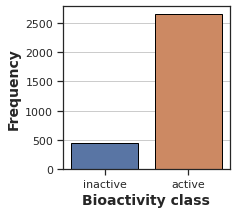

In [ ]:
# Frequency chart between bioactivity
plt.figure(figsize=(3, 3))
plt.grid()
sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

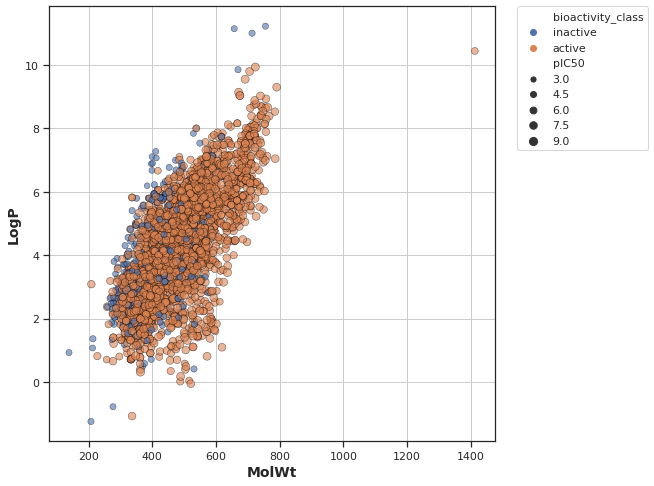

In [ ]:
# Scatter plot of Molecule wight versus LogP
plt.figure(figsize=(8, 8))
plt.grid()
sns.scatterplot(x='MolWt', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.6)
plt.xlabel('MolWt', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
# idealy, logP < 5 and MolWt < 500 are good for abosorption or excretion
# larger circle size means higher pIC50, higher pIC50 means greater potency

## Box plots for descriptors

Text(0, 0.5, 'pIC50 value')

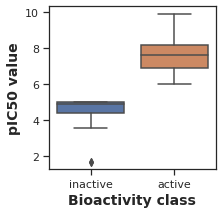

In [ ]:
# boxplot for pIC50
plt.figure(figsize=(3, 3))
sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')
# threshold:
# if pIC50 < 5, classfy inactive
# if pIC50 > 6, classfy active

Text(0, 0.5, 'MolWt')

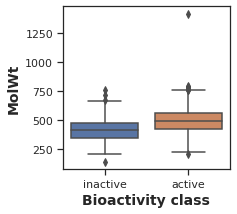

In [ ]:
# boxplot for Molecular weight
plt.figure(figsize=(3, 3))
sns.boxplot(x = 'bioactivity_class', y = 'MolWt', data = df_2class)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MolWt', fontsize=14, fontweight='bold')

Text(0, 0.5, 'LogP')

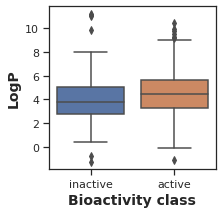

In [ ]:
# boxplot for LogP
plt.figure(figsize=(3, 3))
sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

Text(0, 0.5, 'NumHDonors')

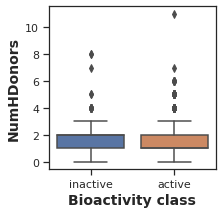

In [ ]:
# boxplot for Number of hydrogen bond donors
plt.figure(figsize=(3, 3))
sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

Text(0, 0.5, 'NumHAcceptors')

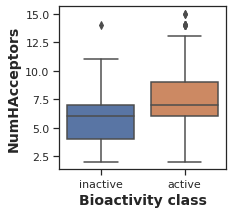

In [ ]:
# boxplot for Number of hydrogen bond acceptors
plt.figure(figsize=(3, 3))
sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

## Mann-Whitney U Test for the above 5 Lipinski's descriptors

In [ ]:
# define the function first for mann whiteney test (non-parameter test)
# using this test because it doesn't need the data to have normal distribution
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

  seed(1)

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# create interpretion wording
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  return results

In [ ]:
print("H0: The two populations are equal versus\nHa: The two populations are not equal\n")
mannwhitney('pIC50')

H0: The two populations are equal versus
Ha: The two populations are not equal



,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,2.556956e-251,0.05,Different distribution (reject H0)


In [ ]:
print("H0: The two populations are equal versus\nHa: The two populations are not equal\n")
mannwhitney('MolWt')

H0: The two populations are equal versus
Ha: The two populations are not equal



,Descriptor,Statistics,p,alpha,Interpretation
0,MolWt,327937.0,1.880243e-51,0.05,Different distribution (reject H0)


In [ ]:
print("H0: The two populations are equal versus\nHa: The two populations are not equal\n")
mannwhitney('LogP')

H0: The two populations are equal versus
Ha: The two populations are not equal



,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,486137.5,1.116466e-09,0.05,Different distribution (reject H0)


In [ ]:
print("H0: The two populations are equal versus\nHa: The two populations are not equal\n")
mannwhitney('NumHDonors')

H0: The two populations are equal versus
Ha: The two populations are not equal



,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,535121.0,0.000471,0.05,Different distribution (reject H0)


In [ ]:
print("H0: The two populations are equal versus\nHa: The two populations are not equal\n")
mannwhitney('NumHAcceptors')

H0: The two populations are equal versus
Ha: The two populations are not equal



,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,308252.0,1.812558e-60,0.05,Different distribution (reject H0)


# Step 4 Calculate descriptor again (Pubchem descriptor)

## Preparation and calculation

**Read before process**: The differece between Pubchem descriptor and Lipiniski descriptors(In step 3):

Lipiniski is more general. Macro level. Compounds' general information

Pubchem is specific, micro level, like fingerprint for each compound

In [ ]:
import pandas as pd
df_final = pd.read_csv('/content/bioactivity_final.csv')

In [ ]:
# Filter out compounds that meet lipiniski rule of 5, so they are better for oral drug.
print(df_final.shape)
df_final2 = df_final[(df_final['MolWt'] < 500) & (df_final['LogP'] < 5) & (df_final['LogP'] > 0) & 
                     (df_final['NumHDonors'] < 5) & (df_final['NumHAcceptors'] < 10)
                     |(df_final['MolWt'] > 500) & (df_final['LogP'] < 5) & (df_final['LogP'] > 0) & 
                     (df_final['NumHDonors'] < 5) & (df_final['NumHAcceptors'] < 10)
                     |(df_final['MolWt'] < 500) & (df_final['LogP'] > 5) & (df_final['LogP'] > 0) & 
                     (df_final['NumHDonors'] < 5) & (df_final['NumHAcceptors'] < 10)
                     |(df_final['MolWt'] < 500) & (df_final['LogP'] < 5) & (df_final['LogP'] > 0) & 
                     (df_final['NumHDonors'] > 5) & (df_final['NumHAcceptors'] < 10)
                     |(df_final['MolWt'] > 500) & (df_final['LogP'] < 5) & (df_final['LogP'] > 0) & 
                     (df_final['NumHDonors'] < 5) & (df_final['NumHAcceptors'] > 10)]
df_final2 = df_final2.reset_index()
df_final2.to_csv('bioactivity_final_meetruleof5.csv')                     
print(df_final2.shape)
df_final2.tail()
# at this point, check the shape after all the filtering and preprocessing
# if the shape is too small(like <200 or 300), i recommend stop now, and go back to step 1 change to another target.
# small dataset is not good for model building, especially we'll split it into training and validation

(3522, 9)
(2433, 10)


,index,Unnamed: 0,molecule_chembl_id,canonical_smiles,bioactivity_class,MolWt,LogP,NumHDonors,NumHAcceptors,pIC50
2428,3517,3517,CHEMBL4568087,Cn1cc(-c2cnc3c(-c4csc(C(=O)N[C@@H]5CCCC[C@@H]5...,active,421.530,2.85800,2.0,8.0,6.387216
2429,3518,3518,CHEMBL4552628,Cc1sc(C(=O)N[C@@H]2[C@H](N)CCCC2(F)F)cc1-c1cnn...,intermediate,425.892,3.66452,2.0,6.0,5.070581
2430,3519,3519,CHEMBL4593677,CC1=C(C#N)C(c2ccc3[nH]nc(C)c3c2)C(C#N)=C(C)N1,active,289.342,3.15328,2.0,4.0,9.000000
2431,3520,3520,CHEMBL4522773,CC1=C(C#N)[C@@H](c2ccc3[nH]nc(C)c3c2)C(C#N)=C(...,inactive,385.858,4.94398,2.0,4.0,4.958607
2432,3521,3521,CHEMBL4097778,CN1C(=O)[C@@H](N2CCc3cn(CC4CCS(=O)(=O)CC4)nc3C...,active,458.540,1.13020,0.0,7.0,6.000000


In [ ]:
# silence execution,remove %%capture if you want to see output
%%capture
# download PaDEL-Descriptor and unzip it
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
! unzip padel.zip

In [ ]:
# select out below two columns, and calculated fingerprint
selection = ['canonical_smiles','molecule_chembl_id']
df_selectionstep4 = df_final2[selection]
df_selectionstep4.to_csv('molecule.smi', sep='\t', index=False, header=False)
# after this, it will output a file "descriptors_output.csv" on the left
# might take several minutes
! cat padel.sh
! bash padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv
Processing CHEMBL115220 in molecule.smi (1/2433). 
Processing CHEMBL101683 in molecule.smi (2/2433). 
Processing CHEMBL281957 in molecule.smi (4/2433). Average speed: 3.59 s/mol.
Processing CHEMBL101253 in molecule.smi (3/2433). Average speed: 6.97 s/mol.
Processing CHEMBL419409 in molecule.smi (6/2433). Average speed: 2.08 s/mol.
Processing CHEMBL2111784 in molecule.smi (5/2433). Average speed: 2.70 s/mol.
Processing CHEMBL121405 in molecule.smi (8/2433). Average speed: 1.57 s/mol.
Processing CHEMBL120185 in molecule.smi (7/2433). Average speed: 1.87 s/mol.
Processing CHEMBL47203 in molecule.smi (9/2433). Average speed: 1.46 s/mol.
Processing CHEMBL118258 in molecule.smi (10/2433). Average speed: 1.31 s/mol.
Processing CHEMBL401930 in molecule.smi (12/2433).

In [ ]:
# X variables
df_X = pd.read_csv('descriptors_output.csv')
df_X = df_X.drop(columns=['Name'])
df_X.head(2)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Y variables
df_Y = df_final2['pIC50']
df_Y.head(2)

0    5.0
1    5.0
Name: pIC50, dtype: float64

In [ ]:
# now, put X and Y together into a dataframe
dfXY = pd.concat([df_X,df_Y], axis=1)
# write to csv
dfXY.to_csv('dataformodelbuilding.csv',index=False)
dfXY.head(2)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0


# Step 5 Model building (All models)

In [ ]:
# read csv
import pandas as pd
dfXY = pd.read_csv("dataformodelbuilding.csv")

In [ ]:
# drop out Y variable (pIC50), create X variables (fingerprint)
X = dfXY.drop('pIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,PubchemFP40,PubchemFP41,PubchemFP42,PubchemFP43,PubchemFP44,PubchemFP45,PubchemFP46,PubchemFP47,PubchemFP48,PubchemFP49,PubchemFP50,PubchemFP51,PubchemFP52,PubchemFP53,PubchemFP54,PubchemFP55,PubchemFP56,PubchemFP57,PubchemFP58,PubchemFP59,PubchemFP60,PubchemFP61,PubchemFP62,PubchemFP63,PubchemFP64,PubchemFP65,PubchemFP66,PubchemFP67,PubchemFP68,PubchemFP69,PubchemFP70,PubchemFP71,PubchemFP72,PubchemFP73,PubchemFP74,PubchemFP75,PubchemFP76,PubchemFP77,PubchemFP78,PubchemFP79,PubchemFP80,PubchemFP81,PubchemFP82,PubchemFP83,PubchemFP84,PubchemFP85,PubchemFP86,PubchemFP87,PubchemFP88,PubchemFP89,PubchemFP90,PubchemFP91,PubchemFP92,PubchemFP93,PubchemFP94,PubchemFP95,PubchemFP96,PubchemFP97,PubchemFP98,PubchemFP99,PubchemFP100,PubchemFP101,PubchemFP102,PubchemFP103,PubchemFP104,PubchemFP105,PubchemFP106,PubchemFP107,PubchemFP108,PubchemFP109,PubchemFP110,PubchemFP111,PubchemFP112,PubchemFP113,PubchemFP114,PubchemFP115,PubchemFP116,PubchemFP117,PubchemFP118,PubchemFP119,PubchemFP120,PubchemFP121,PubchemFP122,PubchemFP123,PubchemFP124,PubchemFP125,PubchemFP126,PubchemFP127,PubchemFP128,PubchemFP129,PubchemFP130,PubchemFP131,PubchemFP132,PubchemFP133,PubchemFP134,PubchemFP135,PubchemFP136,PubchemFP137,PubchemFP138,PubchemFP139,PubchemFP140,PubchemFP141,PubchemFP142,PubchemFP143,PubchemFP144,PubchemFP145,PubchemFP146,PubchemFP147,PubchemFP148,PubchemFP149,PubchemFP150,PubchemFP151,PubchemFP152,PubchemFP153,PubchemFP154,PubchemFP155,PubchemFP156,PubchemFP157,PubchemFP158,PubchemFP159,PubchemFP160,PubchemFP161,PubchemFP162,PubchemFP163,PubchemFP164,PubchemFP165,PubchemFP166,PubchemFP167,PubchemFP168,PubchemFP169,PubchemFP170,PubchemFP171,PubchemFP172,PubchemFP173,PubchemFP174,PubchemFP175,PubchemFP176,PubchemFP177,PubchemFP178,PubchemFP179,PubchemFP180,PubchemFP181,PubchemFP182,PubchemFP183,PubchemFP184,PubchemFP185,PubchemFP186,PubchemFP187,PubchemFP188,PubchemFP189,PubchemFP190,PubchemFP191,PubchemFP192,PubchemFP193,PubchemFP194,PubchemFP195,PubchemFP196,PubchemFP197,PubchemFP198,PubchemFP199,PubchemFP200,PubchemFP201,PubchemFP202,PubchemFP203,PubchemFP204,PubchemFP205,PubchemFP206,PubchemFP207,PubchemFP208,PubchemFP209,PubchemFP210,PubchemFP211,PubchemFP212,PubchemFP213,PubchemFP214,PubchemFP215,PubchemFP216,PubchemFP217,PubchemFP218,PubchemFP219,PubchemFP220,PubchemFP221,PubchemFP222,PubchemFP223,PubchemFP224,PubchemFP225,PubchemFP226,PubchemFP227,PubchemFP228,PubchemFP229,PubchemFP230,PubchemFP231,PubchemFP232,PubchemFP233,PubchemFP234,PubchemFP235,PubchemFP236,PubchemFP237,PubchemFP238,PubchemFP239,PubchemFP240,PubchemFP241,PubchemFP242,PubchemFP243,PubchemFP244,PubchemFP245,PubchemFP246,PubchemFP247,PubchemFP248,PubchemFP249,...,PubchemFP631,PubchemFP632,PubchemFP633,PubchemFP634,PubchemFP635,PubchemFP636,PubchemFP637,PubchemFP638,PubchemFP639,PubchemFP640,PubchemFP641,PubchemFP642,PubchemFP643,PubchemFP644,PubchemFP645,PubchemFP646,PubchemFP647,PubchemFP648,PubchemFP649,PubchemFP650,PubchemFP651,PubchemFP652,PubchemFP653,PubchemFP654,PubchemFP655,PubchemFP656,PubchemFP657,PubchemFP658,PubchemFP659,PubchemFP660,PubchemFP661,PubchemFP662,PubchemFP663,PubchemFP664,PubchemFP665,PubchemFP666,PubchemFP667,PubchemFP668,PubchemFP669,PubchemFP670,PubchemFP671,PubchemFP672,PubchemFP673,PubchemFP674,PubchemFP675,PubchemFP676,PubchemFP677,PubchemFP678,PubchemFP679,PubchemFP680,PubchemFP681,PubchemFP682,PubchemFP683,PubchemFP684,PubchemFP685,PubchemFP686,PubchemFP687,PubchemFP688,PubchemFP689,PubchemFP690,PubchemFP691,PubchemFP692,PubchemFP693,PubchemFP694,PubchemFP695,PubchemFP6

In [ ]:
# create Y variable (pIC50)
Y = dfXY['pIC50']
Y

0       5.000000
1       5.000000
2       5.000000
3       4.000000
4       5.000000
          ...   
2428    6.387216
2429    5.070581
2430    9.000000
2431    4.958607
2432    6.000000
Name: pIC50, Length: 2433, dtype: float64

In [ ]:
# if variance is low, a feature(column) is approximately constant
# include them will not improve the performance of the model
# it's safe to remove them
print("X before removing low variance: " + str(X.shape))
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
print("X after removing low variance: " + str(X.shape))

In [ ]:
# package for cheating, it calculates many models
# top one would be the best. i recommend choosing rf(random forest), the most popular model for drug discovery
from pycaret.regression import *
#set_config('seed', 999)
setup(data = dfXY,target='pIC50',train_size=0.8,silent=True, session_id=12)
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6444,0.7590,0.8692,0.5951,0.1169,0.1021,0.284
rf,Random Forest Regressor,0.6523,0.7817,0.8820,0.5840,0.1191,0.1040,4.233
gbr,Gradient Boosting Regressor,0.7677,0.9493,0.9729,0.4939,0.1318,0.1227,1.110
knn,K Neighbors Regressor,0.7168,0.9568,0.9776,0.4882,0.1319,0.1157,0.438
br,Bayesian Ridge,0.7863,0.9970,0.9974,0.4682,0.1350,0.1250,0.904
ridge,Ridge Regression,0.7837,1.0304,1.0139,0.4507,0.1370,0.1239,0.063
huber,Huber Regressor,0.7960,1.0809,1.0382,0.4242,0.1419,0.1274,1.212
omp,Orthogonal Matching Pursuit,0.8165,1.0945,1.0448,0.4154,0.1409,0.1301,0.063
et,Extra Trees Regressor,0.7513,1.1613,1.0750,0.3797,0.1431,0.1174,5.592
dt,Decision Tree Regressor,0.7655,1.2185,1.1001,0.3496,0.1472,0.1200,0.098


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# then we select the model above. Check R2 or MAE. 
# then change name in the quotation. for example: lightgbm, ada, rf...
lgm = create_model('lightgbm',fold=10)
# this code will performe a 10-fold cross validation

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6409,0.7286,0.8536,0.6243,0.1133,0.0987
1,0.5874,0.6492,0.8057,0.6248,0.1070,0.0935
2,0.6150,0.6710,0.8192,0.6335,0.1134,0.0991
3,0.6466,0.7553,0.8691,0.6271,0.1226,0.1078
4,0.6700,0.8982,0.9477,0.5897,0.1262,0.1061
5,0.6594,0.7508,0.8665,0.5698,0.1151,0.1039
6,0.6762,0.8123,0.9013,0.5362,0.1181,0.1019
7,0.6043,0.6606,0.8128,0.6702,0.1093,0.0961
8,0.7455,0.9852,0.9926,0.4640,0.1322,0.1177
9,0.5988,0.6788,0.8239,0.6109,0.1121,0.0961


In [ ]:
# tuning the model to get some improvement
# can tune mae, mse, r2... change name in quotation
lgm = tune_model(lgm,n_iter=50,optimize="mse")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6272,0.6855,0.8279,0.6466,0.1106,0.0972
1,0.6030,0.6432,0.8020,0.6282,0.1069,0.0967
2,0.6095,0.6555,0.8096,0.6420,0.1112,0.0976
3,0.6879,0.8319,0.9121,0.5893,0.1300,0.1146
4,0.6935,0.8927,0.9448,0.5922,0.1268,0.1098
5,0.6625,0.7342,0.8568,0.5794,0.1133,0.1034
6,0.6629,0.8001,0.8945,0.5432,0.1177,0.1003
7,0.6569,0.7355,0.8576,0.6329,0.1156,0.1041
8,0.7641,1.0009,1.0004,0.4555,0.1331,0.1199
9,0.6213,0.7268,0.8525,0.5834,0.1143,0.0976


In [ ]:
# actual vs predicted value
plot_model(lgm, 'error')

In [ ]:
plot_model(lgm,'rfe')

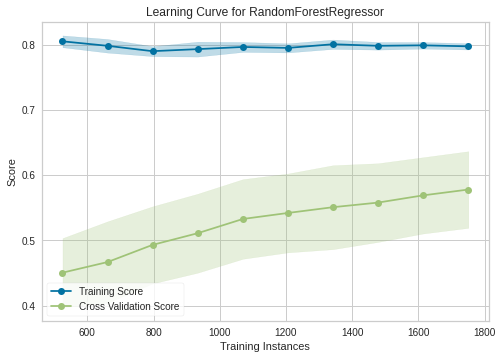

In [ ]:
plot_model(lgm, 'learning')
# interpretation:  If the training score is much greater than the validation score,
# then the model probably requires more training examples in order to generalize more effectively.
# else: not going to benefit from adding more data

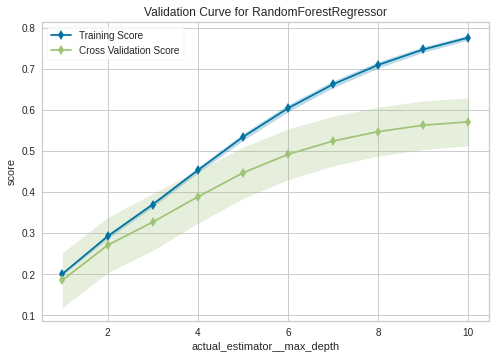

In [ ]:
plot_model(lgm, 'vc')

In [ ]:
plot_model(lgm,'manifold')

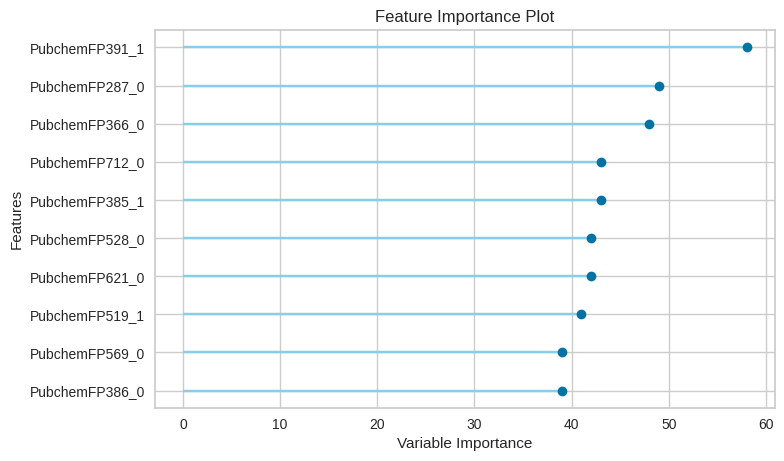

In [ ]:
# check which x variable(fingerprint) is the most important
plot_model(lgm, 'feature')

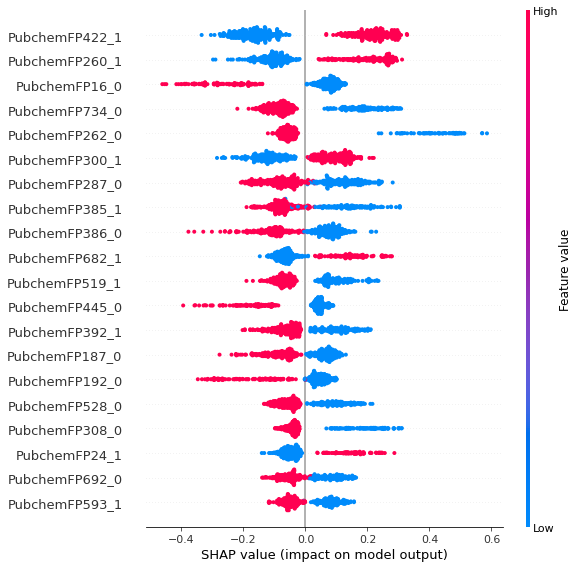

In [ ]:
interpret_model(lgm)

In [ ]:
# warning: this code might freeze your colab, be careful
evaluate_model(lgm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
# actual pIC50 value vs predicted value
prediction_holdout = predict_model(rf)
prediction_holdout[prediction_holdout.columns[-2:]]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.7167,0.9001,0.9487,0.5431,0.1282,0.1149


,pIC50,Label
0,6.420217,7.359130
1,5.000000,5.494188
2,6.638272,6.815603
3,7.585027,7.231139
4,7.823909,7.841080
...,...,...
326,8.397940,8.150228
327,7.086186,7.614912
328,6.000000,5.845403
329,7.920819,8.208824


# Step 6 Model building(manually coding)

In [ ]:
#silence execution, and install shap library
%%capture
!pip install shap

In [ ]:
#read csv and import necessary libraries
import shap
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
dfXY = pd.read_csv("dataformodelbuilding.csv")

In [ ]:
# import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
X = dfXY.drop('pIC50', axis=1)
Y = dfXY['pIC50']
# split in to training and test dataset, this case, 80% training and 20% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=789)
print("X training : " + str(X_train.shape), " Y training : "+ str(Y_train.shape))
print("X test : " + str(X_test.shape), " Y test : "+ str(Y_test.shape))

X training : (1946, 881)  Y training : (1946,)
X test : (487, 881)  Y test : (487,)


In [ ]:
#after building random forest, print out those performance metrics
import numpy as np
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=50,random_state=12)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

from sklearn import metrics
print('R Squared:', metrics.r2_score(Y_test, Y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

R Squared: 0.6176613675528093
Mean Absolute Error: 0.6475278882279561
Mean Squared Error: 0.7670848806263921
Root Mean Squared Error: 0.8758338202115696


In [ ]:
#Let's try a 10 fold cross validation, and print the average performance
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


scores = cross_val_score(model, X=X_train, y=Y_train, cv=10,scoring='r2')
print('Cross Validation R Squared: %s' % np.abs(scores))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(np.abs(scores)),np.std(scores)))

scores = cross_val_score(model, X=X_train, y=Y_train, cv=10, n_jobs=1,scoring='neg_mean_absolute_error')
print('\nCross Validation accuracy scores: %s' % np.abs(scores))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(np.abs(scores)),np.std(scores)))

scores = cross_val_score(model, X=X_train, y=Y_train, cv=10, n_jobs=1,scoring='neg_mean_squared_error')
print('\nCross Validation accuracy scores: %s' % np.abs(scores))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(np.abs(scores)),np.std(scores)))

scores = cross_val_score(model, X=X_train, y=Y_train, cv=10, n_jobs=1,scoring='neg_root_mean_squared_error')
print('\nCross Validation accuracy scores: %s' % np.abs(scores))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(np.abs(scores)),np.std(scores)))

Cross Validation R Squared: [0.51968311 0.50532154 0.5621148  0.67763195 0.5793697  0.61525807
 0.62698604 0.59689518 0.63660393 0.49070208]
Cross Validation accuracy: 0.581 +/- 0.058

Cross Validation accuracy scores: [0.68458681 0.69958068 0.62263631 0.60146668 0.69227432 0.60639081
 0.6044054  0.61339313 0.64628263 0.74231075]
Cross Validation accuracy: 0.651 +/- 0.047

Cross Validation accuracy scores: [0.85876006 0.88071327 0.72419795 0.66180281 0.88230637 0.68112968
 0.72404758 0.67179035 0.69296121 0.90563663]
Cross Validation accuracy: 0.768 +/- 0.095

Cross Validation accuracy scores: [0.92669308 0.93846325 0.85099821 0.81351264 0.93931165 0.82530581
 0.85090985 0.81962818 0.83244292 0.95164943]
Cross Validation accuracy: 0.875 +/- 0.054


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<function matplotlib.pyplot.show>

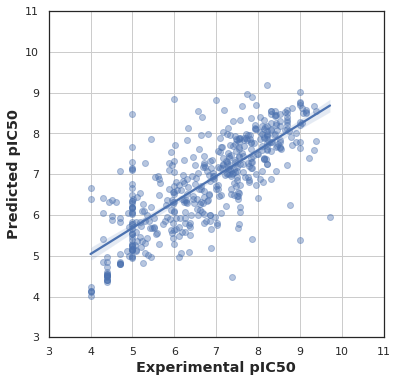

In [ ]:
# See how they the data fit in a graph
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("white")
plt.grid()
ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(3, 11)
ax.set_ylim(3, 11)
ax.figure.set_size_inches(6, 6)
plt.show

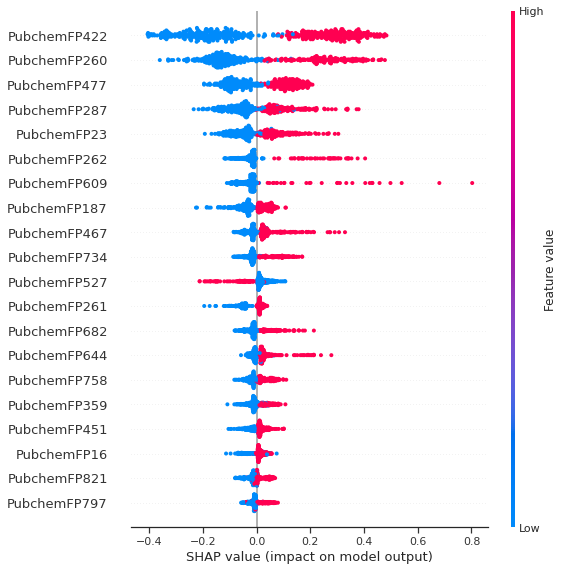

In [ ]:
# shap feature importance chart, very useful
rf = model
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

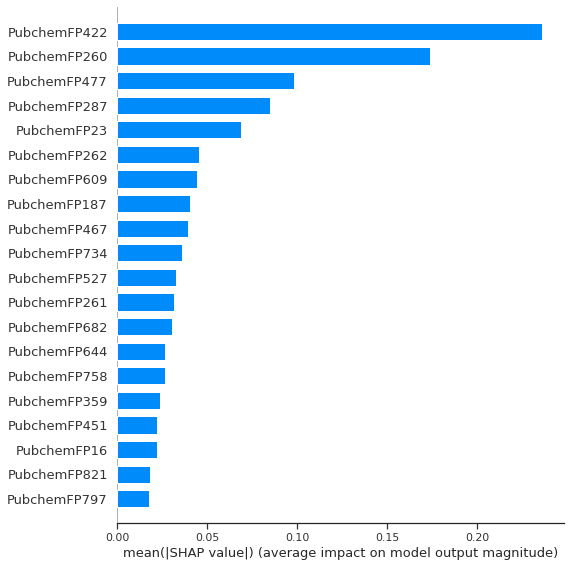

In [ ]:
# traditional version of feature importance, not very useful compare to above
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
#Building SVM this time, print the performance metrics
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf')
svr.fit(X_train, Y_train)
Y_pred = svr.predict(X_test)

print('R Squared:', metrics.r2_score(Y_test, Y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

R Squared: 0.5680427386362056
Mean Absolute Error: 0.6884623692620151
Mean Squared Error: 0.8026448524532658
Root Mean Squared Error: 0.8959044884658552


In [ ]:
# let's do 10 fold cross validation, and take the average performance
svr = SVR(kernel = 'rbf')
scores = cross_val_score(svr, X_train, Y_train, cv=10,scoring='r2')
print('Cross Validation R Squared: %s' % np.abs(scores))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(np.abs(scores)),np.std(scores)))

scores = cross_val_score(svr, X=X_train, y=Y_train, cv=10, n_jobs=1,scoring='neg_mean_absolute_error')
print('\nCross Validation accuracy scores: %s' % np.abs(scores))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(np.abs(scores)),np.std(scores)))

scores = cross_val_score(svr, X=X_train, y=Y_train, cv=10, n_jobs=1,scoring='neg_mean_squared_error')
print('\nCross Validation accuracy scores: %s' % np.abs(scores))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(np.abs(scores)),np.std(scores)))

scores = cross_val_score(svr, X=X_train, y=Y_train, cv=10, n_jobs=1,scoring='neg_root_mean_squared_error')
print('\nCross Validation accuracy scores: %s' % np.abs(scores))
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(np.abs(scores)),np.std(scores)))

Cross Validation R Squared: [0.54136001 0.49485948 0.53087169 0.5119545  0.48285948 0.54395245
 0.52737481 0.49937942 0.53337387 0.58949931]
Cross Validation accuracy: 0.526 +/- 0.029

Cross Validation accuracy scores: [0.69077213 0.68214687 0.76832909 0.69386583 0.76647882 0.68005088
 0.6925086  0.76545661 0.75126835 0.67841817]
Cross Validation accuracy: 0.717 +/- 0.038

Cross Validation accuracy scores: [0.82781867 0.8297726  1.03379171 0.84279448 0.95896424 0.80511682
 0.82874077 1.00300713 0.9199476  0.83612704]
Cross Validation accuracy: 0.889 +/- 0.079

Cross Validation accuracy scores: [0.90984541 0.91091855 1.01675548 0.91803839 0.97926719 0.89728302
 0.910352   1.00150244 0.95913899 0.91439982]
Cross Validation accuracy: 0.942 +/- 0.041


In [ ]:
# save the model, and it'll show on the left files
from sklearn.externals import joblib
joblib.dump(model,'rf_model')

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


['rf_model']

#Step 7 Deployment: testing on other target. Use them as new test sets

In [ ]:
import pandas as pd
import numpy as np
# this is for BTK-lyphoma
df1 = pd.read_csv("/content/dataformodelbuilding.csv")
X = df1.drop('pIC50', axis=1)
Y = df1['pIC50']

In [ ]:
# load the saved random forest model again
rf = joblib.load('rf_model')
yhat = rf.predict(X)
pd.DataFrame({'y':Y,'yhat':yhat})

,y,yhat
0,5.000000,5.741855
1,4.537602,5.682319
2,4.828274,5.576810
3,4.397940,5.582856
4,5.000000,4.848387
...,...,...
727,8.397940,5.735927
728,7.000000,6.899072
729,6.000000,6.193755
730,6.000000,6.318104


In [ ]:
# get r2, mae
print('R Squared:', metrics.r2_score(Y, yhat))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y, yhat)) 

R Squared: -0.593268804218309
Mean Absolute Error: 1.2935835147055914


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<function matplotlib.pyplot.show>

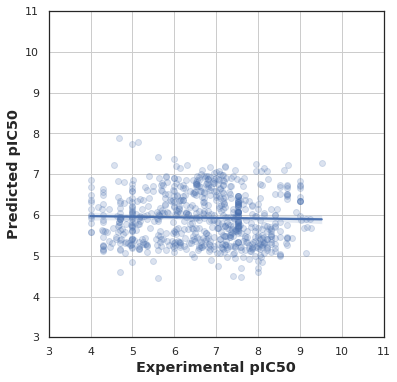

In [ ]:
#let's see whether the new test set fits well or not
y = pd.DataFrame(Y)
df2 = pd.DataFrame(yhat)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("white")
plt.grid()
ax = sns.regplot(Y, yhat, scatter_kws={'alpha':0.2})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(3, 11)
ax.set_ylim(3, 11)
ax.figure.set_size_inches(6, 6)
plt.show